In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/building-info/Building_Footprint.kml
/kaggle/input/geotif-file/sentinel2_multiband.tif
/kaggle/input/closest-date-geotif/sentinel2_multiband_low_cloud_2.tif
/kaggle/input/training-data/Training_data_uhi_index_2025.csv
/kaggle/input/training-data/Submission_template_UHI2025-v2.csv
/kaggle/input/training-data/NY_Mesonet_Weather.xlsx


In [11]:
!pip install rioxarray stackstac pystac_client planetary_computer odc.stac osmnx rioxarray matplotlib geopandas folium fiona shapely pyproj fastkml


In [26]:
# Supress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rioxarray as rio
import rasterio
from matplotlib.cm import RdYlGn,jet,RdBu

# Import Planetary Computer tools
import stackstac
import pystac_client
import planetary_computer 
from odc.stac import stac_load

import numpy as np
import pandas as pd

from pyproj import Transformer
from tqdm import tqdm

import geopandas as gpd
from shapely.geometry import Polygon

In [27]:

building_file_path = "/kaggle/input/building-data/Building_Footprint.kml"
gdf = gpd.read_file(building_file_path)
print(gdf.head())


  Name Description                                           geometry
0                   MULTIPOLYGON (((-73.91903 40.8482, -73.91933 4...
1                   MULTIPOLYGON (((-73.92195 40.84963, -73.92191 ...
2                   MULTIPOLYGON (((-73.9205 40.85011, -73.92045 4...
3                   MULTIPOLYGON (((-73.92056 40.8514, -73.92053 4...
4                   MULTIPOLYGON (((-73.91234 40.85218, -73.91247 ...


In [28]:
gdf_buildings = gdf.to_crs(epsg=3857)

# === Step 2: Create a 500m x 500m Grid ===
grid_size = 500  # Grid size in meters
bounds = gdf_buildings.total_bounds  # MinX, MinY, MaxX, MaxY

[-8237897.1826025   4975725.18569922 -8223082.28590394  4993085.60720934]


<Figure size 1000x600 with 0 Axes>

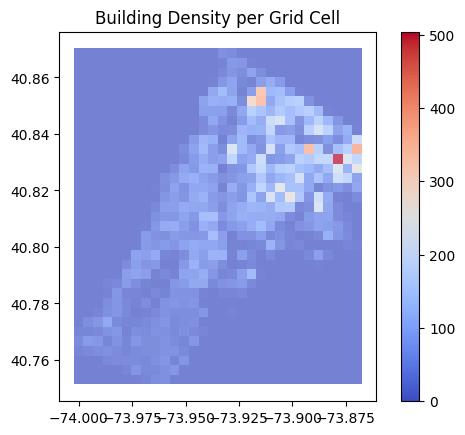

✅ Building density computed and saved to 'building_density.csv' and 'building_density.geojson'.


In [30]:
gdf_buildings = gdf.to_crs(epsg=3857)

# === Step 2: Create a 500m x 500m Grid ===
grid_size = 500  # Grid size in meters
bounds = gdf_buildings.total_bounds  # MinX, MinY, MaxX, MaxY
print(bounds)

grid_cells = []
for x in np.arange(bounds[0], bounds[2], grid_size):
    for y in np.arange(bounds[1], bounds[3], grid_size):
        grid_cells.append(Polygon([(x, y), (x+grid_size, y), (x+grid_size, y+grid_size), (x, y+grid_size)]))

# Convert to GeoDataFrame
gdf_grid = gpd.GeoDataFrame(geometry=grid_cells, crs="EPSG:3857")

# === Step 3: Compute Building Density ===
gdf_grid["building_count"] = gdf_grid.apply(
    lambda row: gdf_buildings.within(row.geometry).sum(), axis=1
)

# Convert Grid Size to km² for Density Calculation
grid_area_km2 = (grid_size / 1000) ** 2  # Convert to km²
gdf_grid["building_density"] = gdf_grid["building_count"] / grid_area_km2

# Convert back to WGS84 for visualization
gdf_grid = gdf_grid.to_crs(epsg=4326)

# === Step 4: Save and Visualize ===
# Save results to CSV
gdf_grid.to_file("building_density.geojson", driver="GeoJSON")
gdf_grid.to_csv("building_density.csv", index=False)

# Plot Density Heatmap
plt.figure(figsize=(10, 6))
gdf_grid.plot(column="building_density", cmap="coolwarm", legend=True, alpha=0.7)
plt.title("Building Density per Grid Cell")
plt.show()

print("✅ Building density computed and saved to 'building_density.csv' and 'building_density.geojson'.")

In [ ]:
file_path = "/kaggle/input/training-data/NY_Mesonet_Weather.xlsx"

In [ ]:
bronx_df= pd.read_excel(file_path,sheet_name="Bronx")
manhattan_df= pd.read_excel(file_path,sheet_name="Manhattan")
bronx_coord = [40.87248,-73.89352]
bronx_altitude = 57.5
manhattan_coord = [40.76754,-73.96449]
manhattan_altitude = 94.8
#data collected every 5 mins during the day, from 3pm to 4pm. The data was then converted to a UHI index using the actual temperature at any location divided by the mean temperature of the dataset. 

In [ ]:
df_combined = pd.concat([bronx_df, manhattan_df], ignore_index=True)

print(df_combined)

In [ ]:
def calculate_heat_index(temp, rh):
    """
    Calculate the heat index (feels-like temperature) based on temperature (Celsius) and relative humidity (%).
    Uses the Rothfusz regression equation.
    """
    T = temp
    RH = rh
    HI = -8.784695 + 1.61139411*T + 2.338549*RH + -0.14611605*T*RH \
         + -0.01230809*T**2 + -0.01642482*RH**2 + 0.00221173*T**2*RH \
         + 0.00072546*T*RH**2 + -0.00000358*T**2*RH**2
    return HI

df_combined["heat_index"] = df_combined.apply(lambda row: calculate_heat_index(row["Air Temp at Surface [degC]"], row["Relative Humidity [percent]"]), axis=1)
df_combined.drop(columns =["Air Temp at Surface [degC]","Relative Humidity [percent]" ] ) #cannot be used as they are directcalc in UHI

may possibly need to do extrapolation or fit a formula to get minute level data for each column data 

1. Why Cloud Cover is Typically Filtered Out
Most UHI studies remove cloudy images because:

Clouds obscure land surface temperature (LST) readings.
Satellite sensors (like Landsat 8 and MODIS) measure surface temperature, but clouds block infrared radiation from reaching the sensor.
This leads to missing or inaccurate LST values in cloudy regions.
Short-term cloud cover does not significantly influence long-term UHI patterns.
UHI is a long-term phenomenon, and short-term cloud cover fluctuates daily.
If we kept cloudy images, we'd get biased and incomplete data, since UHI is measured over weeks/months, not hours.
Clouds cool the surface temporarily but don’t remove urban heating effects.
If a cloud moves over a city, temperatures drop temporarily.
However, the overall UHI intensity remains, because urban materials (e.g., asphalt, buildings) retain heat long after clouds disappear.
Thus, filtering clouds ensures that the retrieved land surface temperature is reliable.

2. Why You Might Include Cloud Cover in Your UHI Model
While cloudy images distort satellite temperature data, cloud cover still affects UHI in different ways:

Clouds trap heat at night (reducing heat loss).
This increases nighttime UHI intensity (nocturnal UHI effect).
Clouds reflect solar radiation during the day (cooling effect).
This reduces daytime UHI intensity.
Seasonal variations in cloud cover can impact UHI trends.
In some regions, wet vs. dry seasons have different UHI intensities due to cloud patterns.
Thus, while cloud-covered satellite images are not useful, meteorological cloud cover data (percentage of cloud cover, humidity, etc.) could be a valuable input feature in your UHI regression model.

3. How to Include Cloud Cover in UHI Prediction
A. Use Ground-Based Cloud Cover Data
Instead of using cloudy satellite images, include cloud cover data from meteorological stations.
Data sources:
ERA5 reanalysis data (global cloud cover estimates from ECMWF).
NOAA Weather Stations (historical cloud cover %).
MODIS Cloud Product (MOD06) (measures cloud fraction and optical depth).

intervals are not fixed, planning to get the mean for every minute of data

### Sentinel-2 Bands Summary 
The following list of common bands can be loaded by the Open Data Cube (ODC) stac command.<br><br>
B01 = Coastal Aerosol = 60m <br>
B02 = Blue = 10m <br>
B03 = Green = 10m <br>
B04 = Red = 10m <br>
B05 = Red Edge (704 nm) = 20m <br>
B06 = Red Edge (740 nm) = 20m <br>
B07 = Red Edge (780 nm) = 20m <br>
B08 = NIR (833 nm) = 10m <br>
B8A = NIR (narrow 864 nm) = 20m <br>
B11 = SWIR (1.6 um) = 20m <br>
B12 = SWIR (2.2 um) = 20m
Prioritize SWIR (B11, B12), NIR (B8), visible bands (B2, B3, B4), and vegetation indices (NDVI, NDWI).

In [ ]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

bronx_coord = [40.87248,-73.89352]
bronx_altitude = 57.5
manhattan_coord = [40.76754,-73.96449]

# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

# Define the time window
time_window = "2021-07-24/2021-09-01"

stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["landsat-c2-l2"],
    query={"eo:cloud_cover": {"lt": 20},"platform": {"in": ["landsat-8"]}},
)

items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))


signed_items = [planetary_computer.sign(item).to_dict() for item in items]
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

# to play around with the bands
data1 = stac_load(
    items,
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)

# Scale Factors for the RGB and NIR bands 
scale1 = 0.0000275 
offset1 = -0.2 
data1 = data1.astype(float) * scale1 + offset1

plot_data = data1[["red","green","blue"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=0.25)
plt.show()

In [ ]:
import rich.table

In [ ]:
table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in items[0].assets.items():
    table.add_row(asset_key, asset.title)

table

In [ ]:
filename = "/kaggle/working/landsat2_multiband_low_cloud.tif"

data_slice = data1.isel(time=1)
# Calculate the dimensions of the file
# height = median.dims["latitude"]
# width = median.dims["longitude"]
height = data_slice.dims["latitude"]
width = data_slice.dims["longitude"]
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data_slice.rio.write_crs("epsg:4326", inplace=True)
data_slice.rio.write_transform(transform=gt, inplace=True);
# Create the GeoTIFF output file using the defined parameters 
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=15,compress='lzw',dtype='float64') as dst:
    dst.write(data_slice.coastal, 1)
    dst.write(data_slice.blue, 2)
    dst.write(data_slice.green, 3)
    dst.write(data_slice.red, 4)
    dst.write(data_slice.nir08, 5)
    dst.write(data_slice.swir16, 6)
    dst.write(data_slice.swir22, 7)
    dst.write(data_slice.lwir11, 8)
    dst.write(data_slice.trad, 9)
    dst.write(data_slice.urad, 10)
    dst.write(data_slice.drad, 11)
    dst.write(data_slice.emis, 12)
    dst.write(data_slice.emsd, 13)
    dst.write(data_slice.atran, 14)
    dst.write(data_slice.cdist, 15)
    dst.close()

In [ ]:
# Define the bounding box for the entire data region using (Latitude, Longitude)
# This is the region of New York City that contains our temperature dataset
lower_left = (40.75, -74.01)
upper_right = (40.88, -73.86)

bronx_coord = [40.87248,-73.89352]
bronx_altitude = 57.5
manhattan_coord = [40.76754,-73.96449]

# Calculate the bounds for doing an archive data search
# bounds = (min_lon, min_lat, max_lon, max_lat)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])

# Define the time window
time_window = "2021-07-24/2021-08-01"

stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=planetary_computer.sign_inplace)

search = stac.search(
    bbox=bounds, 
    datetime=time_window,
    collections=["sentinel-2-l2a"],
    query={"eo:cloud_cover": {"lt": 20}},
)

items = list(search.get_items())
print('This is the number of scenes that touch our region:',len(items))


signed_items = [planetary_computer.sign(item).to_dict() for item in items]
# Define the scale according to our selected crs, so we will use degrees
resolution = 10  # meters per pixel 
scale = resolution / 111320.0 # degrees per pixel for crs=4326 

# to play around with the bands
data2 = stac_load(
    items,
    crs="EPSG:4326", # Latitude-Longitude
    resolution=scale, # Degrees
    chunks={"x": 2048, "y": 2048},
    dtype="uint16",
    patch_url=planetary_computer.sign,
    bbox=bounds
)



# Plot sample images from the time series
plot_data = data2[["B04","B03","B02"]].to_array()
plot_data.plot.imshow(col='time', col_wrap=4, robust=True, vmin=0, vmax=2500)
plt.show()

median = data2.median(dim="time").compute()
ndvi_median = (median.B08-median.B04)/(median.B08+median.B04)
# Calculate NDBI for the median mosaic
ndbi_median = (median.B11-median.B08)/(median.B11+median.B08)
# Calculate NDWI for the median mosaic
ndwi_median = (median.B03-median.B08)/(median.B03+median.B08)

In [ ]:
table = rich.table.Table("Asset Key", "Description")
for asset_key, asset in items[0].assets.items():
    table.add_row(asset_key, asset.title)

table

In [ ]:
filename = "/kaggle/working/sentinel2_multiband_low_cloud.tif"

data_slice = data2.isel(time=0)
# Calculate the dimensions of the file
# height = median.dims["latitude"]
# width = median.dims["longitude"]
height = data_slice.dims["latitude"]
width = data_slice.dims["longitude"]
# Define the Coordinate Reference System (CRS) to be common Lat-Lon coordinates
# Define the tranformation using our bounding box so the Lat-Lon information is written to the GeoTIFF
gt = rasterio.transform.from_bounds(lower_left[1],lower_left[0],upper_right[1],upper_right[0],width,height)
data_slice.rio.write_crs("epsg:4326", inplace=True)
data_slice.rio.write_transform(transform=gt, inplace=True);
# Create the GeoTIFF output file using the defined parameters 
with rasterio.open(filename,'w',driver='GTiff',width=width,height=height,
                   crs='epsg:4326',transform=gt,count=15,compress='lzw',dtype='float64') as dst:
    dst.write(data_slice.B01,1)
    dst.write(data_slice.B02,2)
    dst.write(data_slice.B03,3) 
    dst.write(data_slice.B04,4)
    dst.write(data_slice.B05,5)
    dst.write(data_slice.B06,6)
    dst.write(data_slice.B07,7) 
    dst.write(data_slice.B08,8)
    dst.write(data_slice.B09,9)
    dst.write(data_slice.B11,10)
    dst.write(data_slice.B12,11)
    dst.write(data_slice.B8A,12) 
    dst.write(data_slice.AOT,13)
    dst.write(data_slice.SCL,14)
    dst.write(data_slice.WVP,15)
    dst.close()

In [ ]:
def plot_bands(tiff_path, band_names, title_prefix):
    # Open the GeoTIFF file
    with rasterio.open(tiff_path) as src:
        # Read the bands from the GeoTIFF file
        bands = [src.read(i) for i in range(1, len(band_names) + 1)]

    # Determine the grid size based on the number of bands
    grid_size = int(len(band_names) ** 0.5) + 1

    # Plot the bands in a grid
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))

    # Flatten the axes for easier indexing
    axes = axes.flatten()

    # Plot each band
    for i, (band, name) in enumerate(zip(bands, band_names)):
        im = axes[i].imshow(band, cmap='viridis')
        axes[i].set_title(f'{title_prefix} Band [{name}]')
        fig.colorbar(im, ax=axes[i])

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Sentinel bands and their names
sentinel_tiff_path = "/kaggle/working/sentinel2_multiband_low_cloud.tif"
sentinel_band_names = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'AOT', 'SCL', 'WVP']

# Landsat bands and their names
landsat_tiff_path = "/kaggle/working/landsat2_multiband_low_cloud.tif"
landsat_band_names = ['coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'lwir11', 'trad', 'urad', 'drad', 'emis', 'emsd', 'atran', 'cdist']

# Plot Sentinel bands
plot_bands(sentinel_tiff_path, sentinel_band_names, "Sentinel")

# Plot Landsat bands
plot_bands(landsat_tiff_path, landsat_band_names, "Landsat")

In [ ]:
def map_satellite_data(sentinel_tiff_path, landsat_tiff_path, csv_path):
    # Load the GeoTIFF data for Sentinel and Landsat
    sentinel_data = rio.open_rasterio(sentinel_tiff_path)
    landsat_data = rio.open_rasterio(landsat_tiff_path)
    
    sentinel_crs = sentinel_data.rio.crs  # Get CRS from Sentinel GeoTIFF
    landsat_crs = landsat_data.rio.crs  # Get CRS from Landsat GeoTIFF

    if not sentinel_crs or not landsat_crs:
        raise ValueError("No CRS information found in one of the GeoTIFF files.")

    # Read the CSV file containing Latitude and Longitude
    df = pd.read_csv(csv_path)
    latitudes = df['Latitude'].values
    longitudes = df['Longitude'].values

    # Create transformer objects from EPSG:4326 (WGS84) to the GeoTIFF CRS
    sentinel_transformer = Transformer.from_crs("EPSG:4326", sentinel_crs, always_xy=True)
    landsat_transformer = Transformer.from_crs("EPSG:4326", landsat_crs, always_xy=True)

    # Convert lat/lon to GeoTIFF's coordinate system
    sentinel_transformed_coords = [sentinel_transformer.transform(lon, lat) for lat, lon in zip(latitudes, longitudes)]
    landsat_transformed_coords = [landsat_transformer.transform(lon, lat) for lat, lon in zip(latitudes, longitudes)]
    
    # Separate transformed x and y coordinates
    sentinel_x_coords, sentinel_y_coords = zip(*sentinel_transformed_coords)
    landsat_x_coords, landsat_y_coords = zip(*landsat_transformed_coords)

    # Prepare storage for extracted band values
    sentinel_values = {band: [] for band in ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'AOT', 'SCL', 'WVP']}
    landsat_values = {band: [] for band in ['coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'lwir11', 'trad', 'urad', 'drad', 'emis', 'emsd', 'atran', 'cdist']}

    # Extract values for each coordinate from Sentinel
    for x, y in tqdm(zip(sentinel_x_coords, sentinel_y_coords), total=len(sentinel_x_coords), desc="Mapping Sentinel values"):
        for i, band in enumerate(sentinel_values.keys(), start=1):
            sentinel_values[band].append(sentinel_data.sel(x=x, y=y, band=i, method="nearest").values)

    # Extract values for each coordinate from Landsat
    for x, y in tqdm(zip(landsat_x_coords, landsat_y_coords), total=len(landsat_x_coords), desc="Mapping Landsat values"):
        for i, band in enumerate(landsat_values.keys(), start=1):
            landsat_values[band].append(landsat_data.sel(x=x, y=y, band=i, method="nearest").values)

    # Create a DataFrame with the extracted band values
    df_out = pd.DataFrame({
        'Latitude': latitudes,
        'Longitude': longitudes,
        **sentinel_values,
        **landsat_values
    })

    return df_out

In [ ]:
sentinel_tiff_path = "/kaggle/working/sentinel2_multiband_low_cloud.tif"
landsat_tiff_path = "/kaggle/working/landsat2_multiband_low_cloud.tif"
csv_path = "/kaggle/input/training-data/Training_data_uhi_index_2025.csv"

combined_df = map_satellite_data(sentinel_tiff_path, landsat_tiff_path, csv_path)

In [ ]:
combined_df

In [ ]:
# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

In [ ]:
# Combine two datasets vertically (along columns) using pandas concat function.
def combine_two_datasets(dataset1,dataset2):
    '''
    Returns a  vertically concatenated dataset.
    Attributes:
    dataset1 - Dataset 1 to be combined 
    dataset2 - Dataset 2 to be combined
    '''
    
    data = pd.concat([dataset1,dataset2], axis=1)
    return data

In [ ]:
ground_df = pd.read_csv("/kaggle/input/training-data/Training_data_uhi_index_2025.csv")

In [ ]:
# Combining ground data and final data into a single dataset.
uhi_data = combine_two_datasets(ground_df,combined_df)
uhi_data.head()

In [ ]:
# Remove duplicate rows from the DataFrame based on specified columns and keep the first occurrence
columns_to_check = ['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'AOT', 'SCL', 'WVP', 'coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'lwir11', 'trad', 'urad', 'drad', 'emis', 'emsd', 'atran', 'cdist']
for col in columns_to_check:
    # Check if the value is a numpy array and has more than one dimension
    uhi_data[col] = uhi_data[col].apply(lambda x: tuple(x) if isinstance(x, np.ndarray) and x.ndim > 0 else x)

# Now remove duplicates
uhi_data = uhi_data.drop_duplicates(subset=columns_to_check, keep='first')
uhi_data.head()

In [ ]:
# Resetting the index of the dataset
uhi_data=uhi_data.reset_index(drop=True)

In [ ]:
len(uhi_data)

In [ ]:
# Retaining only the columns for B01, B06, NDVI, and UHI Index in the dataset.
# uhi_data_trim = uhi_data[['B01', 'B09', 'WVP', 'nir08', 'lwir11', 'trad', 'urad', 'drad', 'emis', 'emsd', 'atran', 'cdist','UHI Index']]
uhi_data_trim = uhi_data[['B01', 'B09','lwir11', 'trad', 'urad','drad','emis', 'emsd', 'atran', 'cdist','UHI Index']]

In [ ]:
# Split the data into features (X) and target (y), and then into training and testing sets
X = uhi_data_trim.drop(columns=['UHI Index']).values
y = uhi_data_trim ['UHI Index'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=123)

In [ ]:
print(uhi_data_trim)

### Feature selection

In [ ]:
# Machine Learning
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.metrics import r2_score

In [ ]:
# # Scale the training and test data using standardscaler
# uhi_data_f = uhi_data[['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'AOT', 'SCL', 'WVP', 'coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'lwir11', 'trad', 'urad', 'drad', 'emis', 'emsd', 'atran', 'cdist','UHI Index']]
# # Split the data into features (X) and target (y), and then into training and testing sets
# X_f = uhi_data_f.drop(columns=['UHI Index']).values
# y_f = uhi_data_f ['UHI Index'].values
# X_f_train, X_f_test, y_f_train, y_f_test = train_test_split(X_f, y_f, test_size=0.3,random_state=123)
# sc = StandardScaler()
# X_f_train = sc.fit_transform(X_f_train)
# X_f_test = sc.transform(X_f_test)

In [ ]:
# from sklearn.inspection import permutation_importance
# import pandas as pd
# model_rfr = RandomForestRegressor(n_estimators=300, random_state=42)
# model_rfr.fit(X_f_train,y_f_train)
# # Perform permutation importance on trained model
# perm_importance = permutation_importance(
#     model_rfr,  # Your trained Random Forest Regressor
#     X_f_train,   # Training features
#     y_f_train,   # Training target
#     scoring='r2',  # Score used to evaluate importance
#     n_repeats=10,  # Number of times to shuffle each feature
#     random_state=42  # Reproducibility
# )
# X_train_df = pd.DataFrame(X_f_train, columns=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'AOT', 'SCL', 'WVP', 'coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'lwir11', 'trad', 'urad', 'drad', 'emis', 'emsd', 'atran', 'cdist']) 
# # Convert importance scores to DataFrame
# perm_df = pd.DataFrame({
#     'Feature': X_train_df.columns,
#     'Importance': perm_importance.importances_mean  # Mean importance across n_repeats
# })

# # Sort features by importance
# perm_df = perm_df.sort_values(by="Importance", ascending=False)

# # Display feature importance
# print(perm_df)


# #feature importance aligns with random forest feature importance
# # ['B01', 'B09', 'WVP', 'nir08', 'lwir11', 'trad', 'urad', 'drad', 'emis', 'emsd', 'atran', 'cdist','UHI Index']

Using SHAP for feature extraction

In [ ]:
# import shap

# # Initialize SHAP explainer for Random Forest
# explainer = shap.Explainer(model_rfr, X_f_train)
# shap_values = explainer(X_f_train)

# # Summary plot to visualize feature impact
# shap.summary_plot(shap_values, X_f_train)


### Training
adjusted regularization parameters and tree depth

In [ ]:
# Scale the training and test data using standardscaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# Train the Random Forest model on the training data
model_rfr = RandomForestRegressor(n_estimators=300, random_state=42 )
model_rfr.fit(X_train,y_train)
# X_train_df = pd.DataFrame(X_train, columns=['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'AOT', 'SCL', 'WVP', 'coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'lwir11', 'trad', 'urad', 'drad', 'emis', 'emsd', 'atran', 'cdist']) 
# feature_importance = pd.DataFrame({'Feature': X_train_df.columns, 'Importance': model_rfr.feature_importances_})
# feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# print(feature_importance)

In [ ]:
# Train the Random Forest model on the training data
rf_param_grid = {
    "n_estimators": [100, 300, 500],   # Number of trees
    "max_depth": [5, 10, 15, None],    # Tree depth
    "min_samples_split": [2, 5, 10],   # Min samples required to split a node
    "min_samples_leaf": [1, 2, 4]      # Min samples required at leaf node
}
model_rfr_2 = RandomForestRegressor(random_state=42 )
grid_search_rfr = GridSearchCV(estimator=model_rfr_2, param_grid=rf_param_grid, scoring='r2', cv=5, verbose=1, n_jobs=-1)
grid_search_rfr.fit(X_train, y_train)

# Get best model
best_rfr = grid_search_rfr.best_estimator_
print(f"Best Random Forest Parameters: {grid_search_rfr.best_params_}")


In [ ]:
xgb_param_grid = {
    "n_estimators": [100, 300, 500],       # Number of boosting rounds
    "max_depth": [6, 8, 10],               # Tree depth
    "learning_rate": [0.01, 0.1, 0.2],     # Step size shrinkage
    "subsample": [0.7, 0.8, 1.0],          # Fraction of samples used per tree
    "colsample_bytree": [0.7, 0.8, 1.0]    # Fraction of features used per tree
}

# Initialize XGBRegressor
model_xgb_2 = xgb.XGBRegressor(random_state=42, objective='reg:squarederror')

# Perform Grid Search
grid_search_xgb = GridSearchCV(estimator=model_xgb_2, param_grid=xgb_param_grid, scoring='r2', cv=5, verbose=1, n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Get best model
best_xgb = grid_search_xgb.best_estimator_
print(f"Best XGB Parameters: {grid_search_xgb.best_params_}")


In [ ]:
model_ridge = Ridge(alpha=0.5)  # alpha controls the strength of the regularization
model_ridge.fit(X_train, y_train)

In [ ]:
model_lasso = Lasso(alpha=0.5)  # alpha controls the strength of the regularization
model_lasso.fit(X_train, y_train)

In [ ]:
model_en = ElasticNet(alpha=0.1, l1_ratio=0.5)  # l1_ratio controls the mix of L1 and L2
model_en.fit(X_train, y_train)

In [ ]:
model_svr = SVR(C=1.0, epsilon=0.1)  # C controls regularization strength
model_svr.fit(X_train, y_train)

In [ ]:
model_gbm = GradientBoostingRegressor(n_estimators=100, max_depth=3, subsample=0.8, random_state=42)
model_gbm.fit(X_train, y_train)

In [ ]:
model_xgb = xgb.XGBRegressor(n_estimators=300, max_depth=8, learning_rate=0.1, subsample=0.8, random_state=42)
model_xgb.fit(X_train, y_train)

In [ ]:
model = model_rfr

In [ ]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

In [ ]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

With grid search

In [ ]:
model = best_rfr

In [ ]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

In [ ]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

In [ ]:
model = model_xgb

In [ ]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

In [ ]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

With grid search

In [ ]:
model = best_xgb

In [ ]:
# Make predictions on the training data
insample_predictions = model.predict(X_train)

# calculate R-squared score for in-sample predictions
Y_train = y_train.tolist()
r2_score(Y_train, insample_predictions)

In [ ]:
# Make predictions on the test data
outsample_predictions = model.predict(X_test)

# calculate R-squared score for out-sample predictions
Y_test = y_test.tolist()
r2_score(Y_test, outsample_predictions)

Using bagging between xgboost and rfm model
Criteria	Stacking 🏆	Bagging 🔄
Model Diversity	High (Different models complement each other)	Medium (Averaging similar models)
Overfitting Risk	Higher (Meta-model might overfit)	Lower (Averaging reduces overfitting)
Complexity	Higher (Requires training a meta-model)	Lower (Simple weighted averaging)
Data Requirement	Large datasets preferred	Works well even with small datasets
Computational Cost	Higher	Lower

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


# Parameters
num_models = 6  # Number of models in the bagging ensemble
rf_models = []
xgb_models = []
rf_preds = []
xgb_preds = []

# Train multiple RandomForest and XGBoost models on bootstrapped data
for i in range(num_models):
    # Bootstrap sample
    idx = np.random.choice(len(X_train), len(X_train), replace=True)
    X_train_bootstrap, y_train_bootstrap = X_train[idx], y_train[idx]

    # Train RandomForest model
    rf = RandomForestRegressor(n_estimators=300, random_state=i)
    rf.fit(X_train_bootstrap, y_train_bootstrap)
    rf_models.append(rf)

    # Train XGBoost model
    xgb = XGBRegressor(n_estimators=300, max_depth=10, learning_rate=0.1, subsample=0.8, random_state=i)
    xgb.fit(X_train_bootstrap, y_train_bootstrap)
    xgb_models.append(xgb)

    # Store predictions
    rf_preds.append(rf.predict(X_test))
    xgb_preds.append(xgb.predict(X_test))

# Convert list of predictions to array
rf_preds = np.array(rf_preds)
xgb_preds = np.array(xgb_preds)

# Average predictions (Bagging)
final_preds = (rf_preds.mean(axis=0) + xgb_preds.mean(axis=0)) / 2

# Evaluation
r2 = r2_score(y_test, final_preds)
print(f"Bagging Ensemble R2: {r2:.4f}")


Grid search

If your XGBoost or Random Forest model already performs well, adding a meta-model might not improve performance.
K-Fold introduces noise instead of new learning opportunities.
Problem:
If your dataset is small, splitting it into K folds means each fold has even fewer training samples.
This can make base models weaker, leading to less useful meta-features.
K-Fold increases variance in smaller datasets.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split

# Train Base Models
rf = RandomForestRegressor(n_estimators=300, random_state=42)
xgb = XGBRegressor(n_estimators=300, learning_rate=0.1, max_depth=11, random_state=42)

# rf.fit(X_train, y_train)
# xgb.fit(X_train, y_train)

# # Get predictions from base models
# rf_train_preds = rf.predict(X_train)
# xgb_train_preds = xgb.predict(X_train)
# rf_test_preds = rf.predict(X_test)
# xgb_test_preds = xgb.predict(X_test)

# # Stack predictions as new features for the meta-model
# stacked_train = np.column_stack((X_train,rf_train_preds, xgb_train_preds))
# stacked_test = np.column_stack((X_test,rf_test_preds, xgb_test_preds))

# # Train Meta-Model (Can be Linear Regression, XGBoost, or another RF)
# meta_model = XGBRegressor(n_estimators=80, learning_rate=0.1, random_state=42)
# meta_model.fit(stacked_train, y_train)


# Set up K-Fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)

# Create placeholders for out-of-fold (OOF) predictions
oof_preds_rf = np.zeros(len(X_train))
oof_preds_xgb = np.zeros(len(X_train))

# Train models using K-Fold Cross-Validation
for train_idx, val_idx in kf.split(X_train):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    # Train base models on fold
    rf.fit(X_tr, y_tr)
    xgb.fit(X_tr, y_tr)

    # Store out-of-fold predictions
    oof_preds_rf[val_idx] = rf.predict(X_val)
    oof_preds_xgb[val_idx] = xgb.predict(X_val)

# Create stacked features for the meta-model
stacked_train = np.column_stack((oof_preds_rf, oof_preds_xgb))
stacked_test = np.column_stack((rf.predict(X_test), xgb.predict(X_test)))

# Train Meta-Model (XGBoost)
meta_model = LinearRegression()
meta_model.fit(stacked_train, y_train)

# Final predictions
final_preds = meta_model.predict(stacked_test)

# Evaluation
r2 = r2_score(y_test, final_preds)
print(f"Stacking Ensemble r2: {r2:.4f}")


### Submission

In [ ]:
#Reading the coordinates for the submission
test_file = pd.read_csv('/kaggle/input/training-data/Submission_template_UHI2025-v2.csv')
test_file.head()

In [ ]:
# Mapping satellite data for submission.

sentinel_tiff_path = "/kaggle/working/sentinel2_multiband_low_cloud.tif"
landsat_tiff_path = "/kaggle/working/landsat2_multiband_low_cloud.tif"
csv_path = '/kaggle/input/training-data/Submission_template_UHI2025-v2.csv'

val_data = map_satellite_data(sentinel_tiff_path, landsat_tiff_path, csv_path)

In [ ]:
val_data.head()

In [ ]:
# Extracting specific columns (B01, B06, and NDVI) from the validation dataset
# submission_val_data=val_data.loc[:,['B01', 'B02', 'B03', 'B04', 'B05', 'B06', 'B07', 'B08', 'B09', 'B11', 'B12', 'B8A', 'AOT', 'SCL', 'WVP', 'coastal', 'blue', 'green', 'red', 'nir08', 'swir16', 'swir22', 'lwir11', 'trad', 'urad', 'drad', 'emis', 'emsd', 'atran', 'cdist']]
submission_val_data=val_data.loc[:,['B01', 'B09','lwir11', 'trad', 'urad','drad','emis', 'emsd', 'atran', 'cdist']]
submission_val_data.head()

In [ ]:
# Feature Scaling 
submission_val_data = submission_val_data.values
transformed_submission_data = sc.transform(submission_val_data)

In [ ]:
#Making predictions
model = best_xgb
final_predictions = model.predict(transformed_submission_data)
final_prediction_series = pd.Series(final_predictions)

In [ ]:
#Combining the results into dataframe
submission_df = pd.DataFrame({'Longitude':test_file['Longitude'].values, 'Latitude':test_file['Latitude'].values, 'UHI Index':final_prediction_series.values})

In [ ]:
#Displaying the sample submission dataframe
submission_df.head()

In [ ]:
#Dumping the predictions into a csv file.
submission_df.to_csv("submission.csv",index = False)